In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, accuracy_score
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns
from sklearn import tree
np.random.seed(42)

### Utils

In [2]:
def remove_au_features(df, au_list):
    for au in au_list:
        df.drop([f'AU{au}_std', f'AU{au}_mean', f'AU{au}_e0_length', f'AU{au}_e1_length', f'AU{au}_e2_length',
                f'AU{au}_e0_amount', f'AU{au}_e1_amount', f'AU{au}_e2_amount',
                f'AU{au}_e0_intensity', f'AU{au}_e1_intensity', f'AU{au}_e2_intensity'], axis=1, inplace=True)


def subsample_labels(df, labels):
    return df.loc[df['label'].isin(labels)]


def over_sample(df, label_='happy', amount=95):
    df_happy = df[df.label == label_]
    df_happy = resample(df_happy,
                        replace=True,     # sample with replacement
                        n_samples=amount,    # to match majority class
                        random_state=42) # reproducible results

    return pd.concat([df, df_happy])


In [60]:
from sklearn.preprocessing import MinMaxScaler

def plot_importance(feature_imp_, top=5):
    print(len(feature_imp_))
    feature_imp_ = feature_imp_[0:top]
    print(feature_imp_)

    plt.figure()
    sns.barplot(x=feature_imp_, y=feature_imp_.index, palette='tab10')
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Feature Importance Score")

def plot_importance_bars(feature_imp_, label_key='group', top=5):
    features = list(feature_imp_.keys())[0:top]
    df_ = df_w_labels[features + [label_key]].copy()

    scaler = MinMaxScaler()
    df_[features] = scaler.fit_transform(df_[features])
    df_melted = pd.melt(df_, id_vars=label_key, var_name='feature', value_name='value')

    plt.figure(figsize=(8, 6))
    colors = ['#9bb5d1', '#d1a693']

    df_melted['feature'] = df_melted['feature'].str.replace('_', '-')
    ax = sns.boxplot(data=df_melted, x='feature', y='value', hue=label_key,
                    showfliers=False, width=0.35,
                    linewidth=1.25)

    ax.get_legend().set_title('')
    ax.set_ylabel('')
    ax.set_xlabel('')

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


def scatter_imp_features(feature_imp_, label_key='group', i1=0, i2=1):
    plt.figure()
    sns.scatterplot(x=feature_imp_.keys()[i1],
                    y=feature_imp_.keys()[i2], hue=label_key,
                    data=df_w_labels, s=15, alpha=0.75)


def hist_imp_features(feature_imp_, label_key='group', i1=0):
    plt.figure()
    sns.histplot(data=df_w_labels, x=feature_imp_.keys()[i1], hue=label_key, bins=20, kde=True, alpha=0.5)

### Clf

In [64]:
df = pd.read_csv('../feature_vector.csv', index_col=0)

print(df['label'].value_counts())
print(df['group'].value_counts())

# df = df[df['group'] == 'coda_speak'] #'hearing', 'C', D

# df = df.replace('coda_speech', 'speaking')
# df = df.replace('hear', 'speaking')
# df = df.replace('coda_sign', 'signing')
# df = df.replace('deaf', 'signing')

# df = df.replace('angry', 'angry_sad')
# df = df.replace('sad', 'angry_sad')

#Over sample
# df = over_sample(df, 'happy', 336-169)
# df = over_sample(df, 'neutral', 336-169)

# remove_au_features(df, ['10','12','15','17'])
# label_names = list(np.unique(labels, return_counts=False))


# label_names = ['coda_speech', 'hear']
label_names = ['coda_sign', 'deaf']

df = df[df.group.isin(label_names)]
# df = df.replace('coda_speech', 'CODA')
# df = df.replace('hear', 'Hearing')
df = df.replace('coda_sign', 'CODA')
df = df.replace('deaf', 'Deaf')

print(df['group'].value_counts())
labels = df['group']
print(len(labels))

# Drop for clf and save a copy
df_w_labels = df.copy()
df.drop(['label', 'group'], axis=1, inplace=True)

label
angry      291
happy      290
sad        290
neutral    288
Name: count, dtype: int64
group
hear           340
deaf           300
coda_sign      260
coda_speech    259
Name: count, dtype: int64
group
Deaf    300
CODA    260
Name: count, dtype: int64
560


In [65]:
X_train, X_test, y_train, y_test = train_test_split(df, labels, random_state=0, test_size=0.3, stratify=labels)
md = 7

In [66]:
clf = RandomForestClassifier(criterion='entropy', max_depth=md)
cv_scores = cross_val_score(clf, df, labels, cv=10)

print(cv_scores)
print(np.mean(cv_scores))

[0.53571429 0.625      0.60714286 0.5        0.71428571 0.39285714
 0.5        0.71428571 0.39285714 0.67857143]
0.5660714285714287


              precision    recall  f1-score   support

        CODA       0.68      0.60      0.64        78
        Deaf       0.69      0.76      0.72        90

    accuracy                           0.68       168
   macro avg       0.68      0.68      0.68       168
weighted avg       0.68      0.68      0.68       168

f1: 0.6795162509448224
prec: 0.6840140535792709
accuracy: 0.6845238095238095
max_depth: 7
121
AU04_mean            0.040255
AU07_std             0.031896
AU09_mean            0.030116
AU17_mean            0.024617
AU10_e0_intensity    0.021541
dtype: float64


C:\Users\dean\AppData\Local\Temp\ipykernel_24548\242627100.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_imp_, y=feature_imp_.index, palette='tab10')


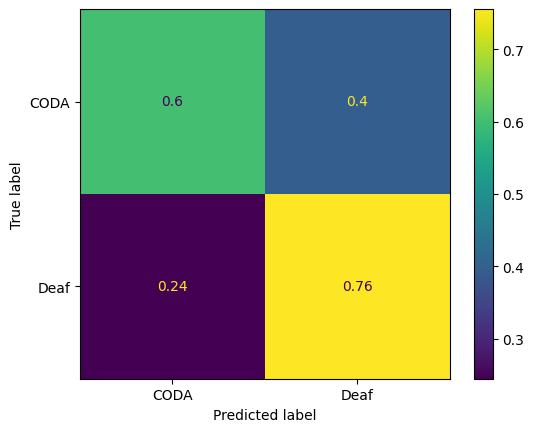

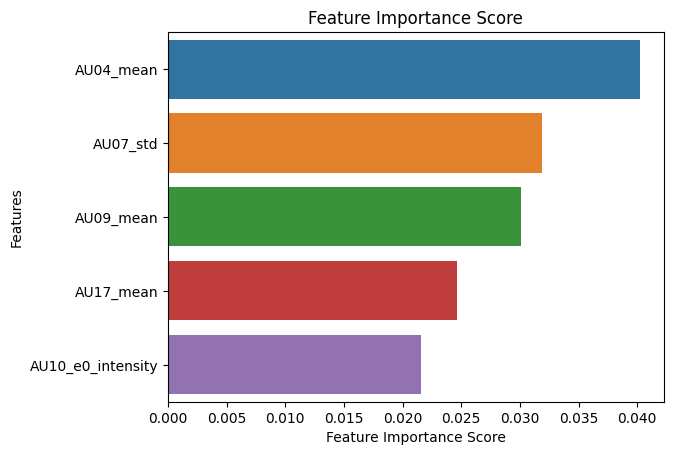

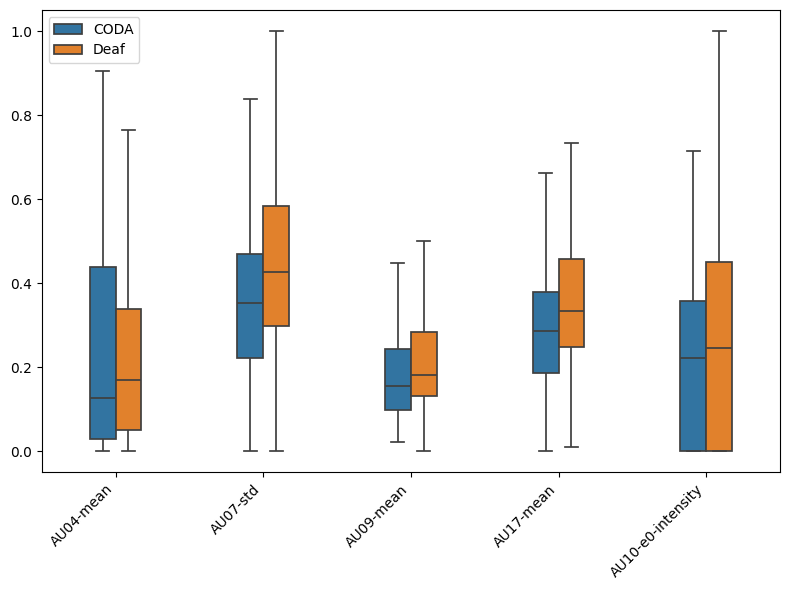

In [69]:
# xtrain = X_train[feature_imp[0:200].index.to_list()]
# xtest = X_test[feature_imp[0:200].index.to_list()]

xtrain = X_train
xtest = X_test

clf = RandomForestClassifier(criterion='entropy', max_depth=md, random_state=47)
clf.fit(xtrain, y_train)
feature_imp_ = pd.Series(clf.feature_importances_, index=df.columns.tolist()).sort_values(ascending=False)

y_pred = clf.predict(xtest)
print(classification_report(y_test, y_pred, labels=clf.classes_))
f1_ = f1_score(y_test, y_pred, average='macro')
prec = precision_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)

print(f'f1: {f1_}')
print(f'prec: {prec}')
print(f'accuracy: {accuracy}')

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
print('max_depth:', md)

label_key = 'group' # in Task2 change to 'label'
plot_importance(feature_imp_)
plot_importance_bars(feature_imp_, label_key)
# scatter_imp_features(feature_imp_, label_key)
# scatter_imp_features(feature_imp_, label_key,0,2)
# hist_imp_features(feature_imp_, label_key,0)

### Stats analysis

In [70]:
from scipy.stats import chi2_contingency

results_df = pd.DataFrame({
    'true': y_test,
    'pred': y_pred,
})

total_cm = confusion_matrix(results_df["true"], results_df["pred"], labels=clf.classes_)
chi2, p, dof, _ = chi2_contingency(total_cm)
print(f"\nChi-squared: {chi2:.3f}, p = {p:.4f}")

# Phi coefficient
def phi_from_cm(cm):
    a, b = cm[0,0], cm[0,1]
    c, d = cm[1,0], cm[1,1]
    num = (a * d) - (b * c)
    denom = np.sqrt((a + b) * (c + d) * (a + c) * (b + d))
    return num / denom if denom != 0 else 0

phi = phi_from_cm(total_cm)
print(f"Effect size (phi coefficient): {phi:.3f}")


Chi-squared: 20.687, p = 0.0000
Effect size (phi coefficient): 0.363


In [71]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, fisher_exact
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def analyze_classification_chi2(results_df, alpha=0.05):

    
    # Create confusion matrix
    confusion_matrix = pd.crosstab(results_df['true'], results_df['pred'], 
                                   rownames=['Actual'], colnames=['Predicted'])
    
    print("=== CONFUSION MATRIX ===")
    print(confusion_matrix)
    
    n = len(results_df)
    print(f"\nSample size: {n}")
    
    # Get basic metrics
    if confusion_matrix.shape == (2, 2):
        tn, fp = confusion_matrix.iloc[0, :]
        fn, tp = confusion_matrix.iloc[1, :]
        
        accuracy = (tp + tn) / n
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
        print(f"Accuracy: {accuracy:.3f}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"F1-score: {f1:.3f}")
    
    # Chi-square test
    chi2_stat, p_value, dof, expected = chi2_contingency(confusion_matrix)
    
    print(f"\n=== CHI-SQUARE TEST ===")
    print(f"Chi-square statistic: {chi2_stat:.4f}")
    print(f"p-value: {p_value:.10f}")
    print(f"Degrees of freedom: {dof}")
    
    # Check assumptions
    min_expected = expected.min()
    if min_expected < 5:
        print(f"⚠️  Warning: Minimum expected frequency = {min_expected:.2f} < 5")
        print("Chi-square test may not be reliable for small samples")
        
        # Use Fisher's exact test for 2x2 tables
        if confusion_matrix.shape == (2, 2):
            oddsratio, fisher_p = fisher_exact(confusion_matrix)
            print(f"\nFisher's exact test p-value: {fisher_p:.4f}")
            print(f"Odds ratio: {oddsratio:.4f}")
    
    # Effect sizes
    print(f"\n=== EFFECT SIZES ===")
    
    # Phi coefficient (same as Cramér's V for 2x2 tables)
    phi = np.sqrt(chi2_stat / n)
    print(f"Phi coefficient: {phi:.4f}")
    
    # Interpret phi coefficient
    if phi < 0.1:
        phi_interp = "negligible"
    elif phi < 0.3:
        phi_interp = "small"
    elif phi < 0.5:
        phi_interp = "medium"
    else:
        phi_interp = "large"
    
    print(f"Phi interpretation: {phi_interp} effect size")
    
    # Cohen's d equivalent for classification (using accuracy vs chance)
    if confusion_matrix.shape == (2, 2):
        # Chance accuracy for balanced classes
        p_pos = confusion_matrix.sum(axis=1).iloc[1] / n  # proportion of positive cases
        chance_accuracy = max(p_pos, 1-p_pos)  # majority class baseline
        
        # Effect size as standardized difference from chance
        accuracy_improvement = accuracy - chance_accuracy
        
        # Approximate Cohen's d using binomial variance
        chance_variance = chance_accuracy * (1 - chance_accuracy)
        cohens_d_approx = accuracy_improvement / np.sqrt(chance_variance) if chance_variance > 0 else 0
        
        print(f"Chance accuracy (majority class): {chance_accuracy:.3f}")
        print(f"Accuracy improvement: {accuracy_improvement:.3f}")
        print(f"Approximate Cohen's d: {cohens_d_approx:.4f}")
        
        # Interpret Cohen's d
        if abs(cohens_d_approx) < 0.2:
            d_interp = "negligible"
        elif abs(cohens_d_approx) < 0.5:
            d_interp = "small"
        elif abs(cohens_d_approx) < 0.8:
            d_interp = "medium"
        else:
            d_interp = "large"
        
        print(f"Cohen's d interpretation: {d_interp} effect size")
    
    # Performance vs chance analysis
    print(f"\n=== PERFORMANCE ANALYSIS ===")
    
    # Expected confusion matrix under independence (chance performance)
    expected_df = pd.DataFrame(expected, 
                              index=confusion_matrix.index, 
                              columns=confusion_matrix.columns)
    print("Expected frequencies under chance performance:")
    print(expected_df.round(2))
    
    # Residuals (observed - expected)
    residuals = confusion_matrix - expected_df
    print(f"\nResiduals (observed - expected):")
    print(residuals.round(2))
    
    # Standardized residuals
    std_residuals = residuals / np.sqrt(expected_df)
    print(f"\nStandardized residuals:")
    print(std_residuals.round(2))
    print("(Values > |2| indicate significant deviations from chance)")
    
    # Summary interpretation
    print(f"\n=== SUMMARY AND INTERPRETATION ===")
    
    if p_value < alpha:
        significance = "significant"
        print(f"✓ Results are statistically significant (p = {p_value:.4f} < {alpha})")
    else:
        significance = "not significant"
        print(f"✗ Results are not statistically significant (p = {p_value:.4f} ≥ {alpha})")
    
    print(f"✓ Effect size (φ = {phi:.4f}) indicates a {phi_interp} practical effect")
    
    if confusion_matrix.shape == (2, 2):
        print(f"✓ Performance improvement over chance (d ≈ {cohens_d_approx:.4f}) shows {d_interp} effect")
        
        if accuracy > chance_accuracy + 0.1:  # 10% improvement threshold
            print(f"✓ Model shows meaningful improvement over baseline ({accuracy:.3f} vs {chance_accuracy:.3f})")
        else:
            print(f"⚠️  Model improvement over baseline is modest ({accuracy:.3f} vs {chance_accuracy:.3f})")
    
    # Recommendations for small samples
    if n < 50:
        print(f"\n⚠️  SMALL SAMPLE CONSIDERATIONS (n = {n}):")
        print("• Focus on effect size interpretation over p-values")
        print("• Consider collecting more data for robust conclusions")
        if min_expected < 5:
            print("• Use Fisher's exact test results for more reliable inference")
    
    return {
        'confusion_matrix': confusion_matrix,
        'chi2_stat': chi2_stat,
        'p_value': p_value,
        'phi_coefficient': phi,
        'sample_size': n,
        'accuracy': accuracy if confusion_matrix.shape == (2, 2) else None,
        'cohens_d_approx': cohens_d_approx if confusion_matrix.shape == (2, 2) else None
    }


analysis_results = analyze_classification_chi2(results_df)


=== CONFUSION MATRIX ===
Predicted  CODA  Deaf
Actual               
CODA         47    31
Deaf         22    68

Sample size: 168
TP: 68, FP: 31, TN: 47, FN: 22
Accuracy: 0.685
Precision: 0.687
Recall: 0.756
F1-score: 0.720

=== CHI-SQUARE TEST ===
Chi-square statistic: 20.6871
p-value: 0.0000054078
Degrees of freedom: 1

=== EFFECT SIZES ===
Phi coefficient: 0.3509
Phi interpretation: medium effect size
Chance accuracy (majority class): 0.536
Accuracy improvement: 0.149
Approximate Cohen's d: 0.2984
Cohen's d interpretation: small effect size

=== PERFORMANCE ANALYSIS ===
Expected frequencies under chance performance:
Predicted   CODA   Deaf
Actual                 
CODA       32.04  45.96
Deaf       36.96  53.04

Residuals (observed - expected):
Predicted   CODA   Deaf
Actual                 
CODA       14.96 -14.96
Deaf      -14.96  14.96

Standardized residuals:
Predicted  CODA  Deaf
Actual               
CODA       2.64 -2.21
Deaf      -2.46  2.05
(Values > |2| indicate significan

### Overfit
1st to see possability and 2nd to see which features are best

              precision    recall  f1-score   support

 coda_speech       0.98      0.98      0.98       259
        hear       0.99      0.99      0.99       340

    accuracy                           0.99       599
   macro avg       0.99      0.99      0.99       599
weighted avg       0.99      0.99      0.99       599

f1: 0.9863956393368158
prec: 0.9863956393368158
max_depth: 7
121
AU05_e1_length    0.048632
AU05_e0_length    0.041264
AU12_mean         0.032500
AU05_e0_amount    0.029132
AU12_std          0.026604
dtype: float64


C:\Users\dean\AppData\Local\Temp\ipykernel_30504\48031629.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_imp_, y=feature_imp_.index, palette='tab10')


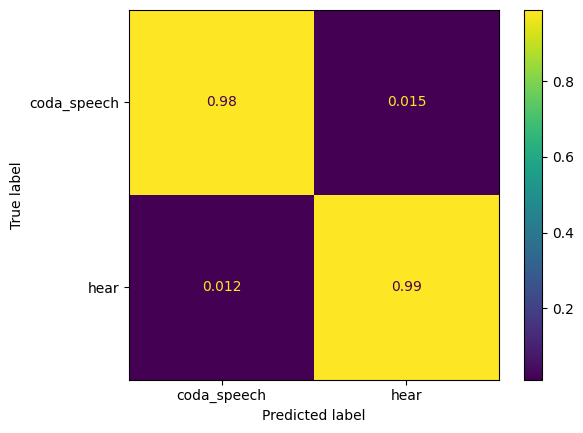

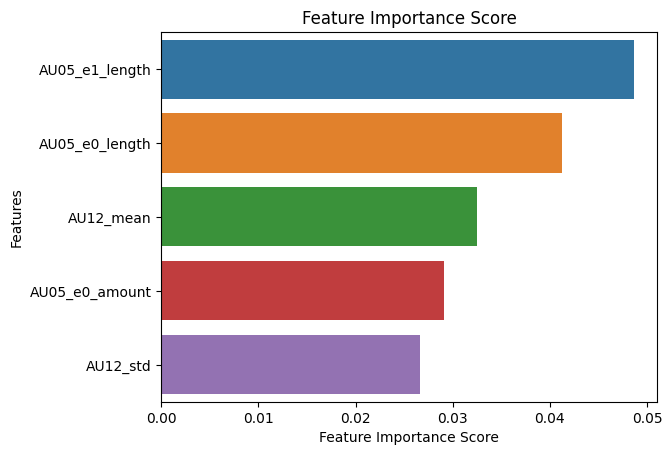

In [ ]:
clf = RandomForestClassifier(criterion='entropy', max_depth=md)
clf.fit(df, labels)

y_pred = clf.predict(df)
print(classification_report(labels, y_pred, labels=clf.classes_))
f1_ = f1_score(labels, y_pred, average='macro')
prec = precision_score(labels, y_pred, average='macro')
print(f'f1: {f1_}')
print(f'prec: {prec}')

cm = confusion_matrix(labels, y_pred, labels=clf.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
print('max_depth:', md)

feature_imp_overfitted = pd.Series(clf.feature_importances_, index=df.columns.tolist()).sort_values(ascending=False)
plot_importance(feature_imp_overfitted)

### cv score as a function of # of features (ascending order)

100%|██████████| 25/25 [01:49<00:00,  4.37s/it]

features: 43 cv: 0.5944752623688156 


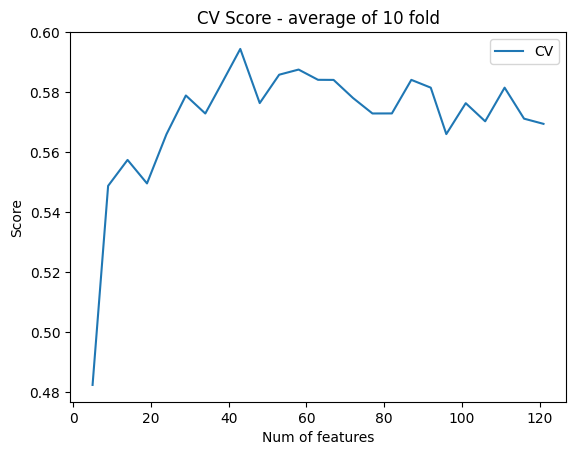

In [ ]:


from tqdm import tqdm
cv_aver = []
fe_range = np.linspace(5, 121, 25).astype(int)
for num_features in tqdm(fe_range):
    df_ = df[feature_imp_[0:num_features].index.to_list()]
    clf = RandomForestClassifier(criterion='entropy', max_depth=11)
    cv_scores = cross_val_score(clf, df_, labels, cv=10)
    cv_aver.append(np.mean(cv_scores))

plt.plot(fe_range, cv_aver, label='CV')
plt.xlabel('Num of features')
plt.ylabel('Score')
plt.title('CV Score - average of 10 fold')
plt.legend()

max_idx = np.argmax(cv_aver)
features_max = fe_range[max_idx]
print(f'features: {features_max} cv: {cv_aver[max_idx]} ')

### Tree Vis

[Text(0.5, 0.875, 'AU15_e1_length <= 1.25\nentropy = 1.991\nsamples = 1159\nvalue = [260, 259, 300, 340]\nclass = hear'),
 Text(0.25, 0.625, 'AU17_std <= 0.376\nentropy = 1.664\nsamples = 614\nvalue = [51, 214, 59, 290]\nclass = hear'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'AU05_e0_length <= 0.5\nentropy = 1.197\nsamples = 378\nvalue = [7.0, 136.0, 8.0, 227.0]\nclass = hear'),
 Text(0.0625, 0.125, 'entropy = 0.757\nsamples = 135\nvalue = [1, 17, 3, 114]\nclass = hear'),
 Text(0.1875, 0.125, 'entropy = 1.265\nsamples = 243\nvalue = [6, 119, 5, 113]\nclass = coda_speech'),
 Text(0.375, 0.375, 'AU15_std <= 0.225\nentropy = 1.966\nsamples = 236\nvalue = [44, 78, 51, 63]\nclass = coda_speech'),
 Text(0.3125, 0.125, 'entropy = 1.681\nsamples = 141\nvalue = [17, 66, 10, 48]\nclass = coda_speech'),
 Text(0.4375, 0.125, 'entropy = 1.837\nsamples = 95\nvalue = [27, 12, 41, 15]\nclass = deaf'),
 Text(0.75, 0.625, 'AU15_mean <= 0.157\nentropy = 1.664\nsamples = 545\nvalue = [209, 45, 

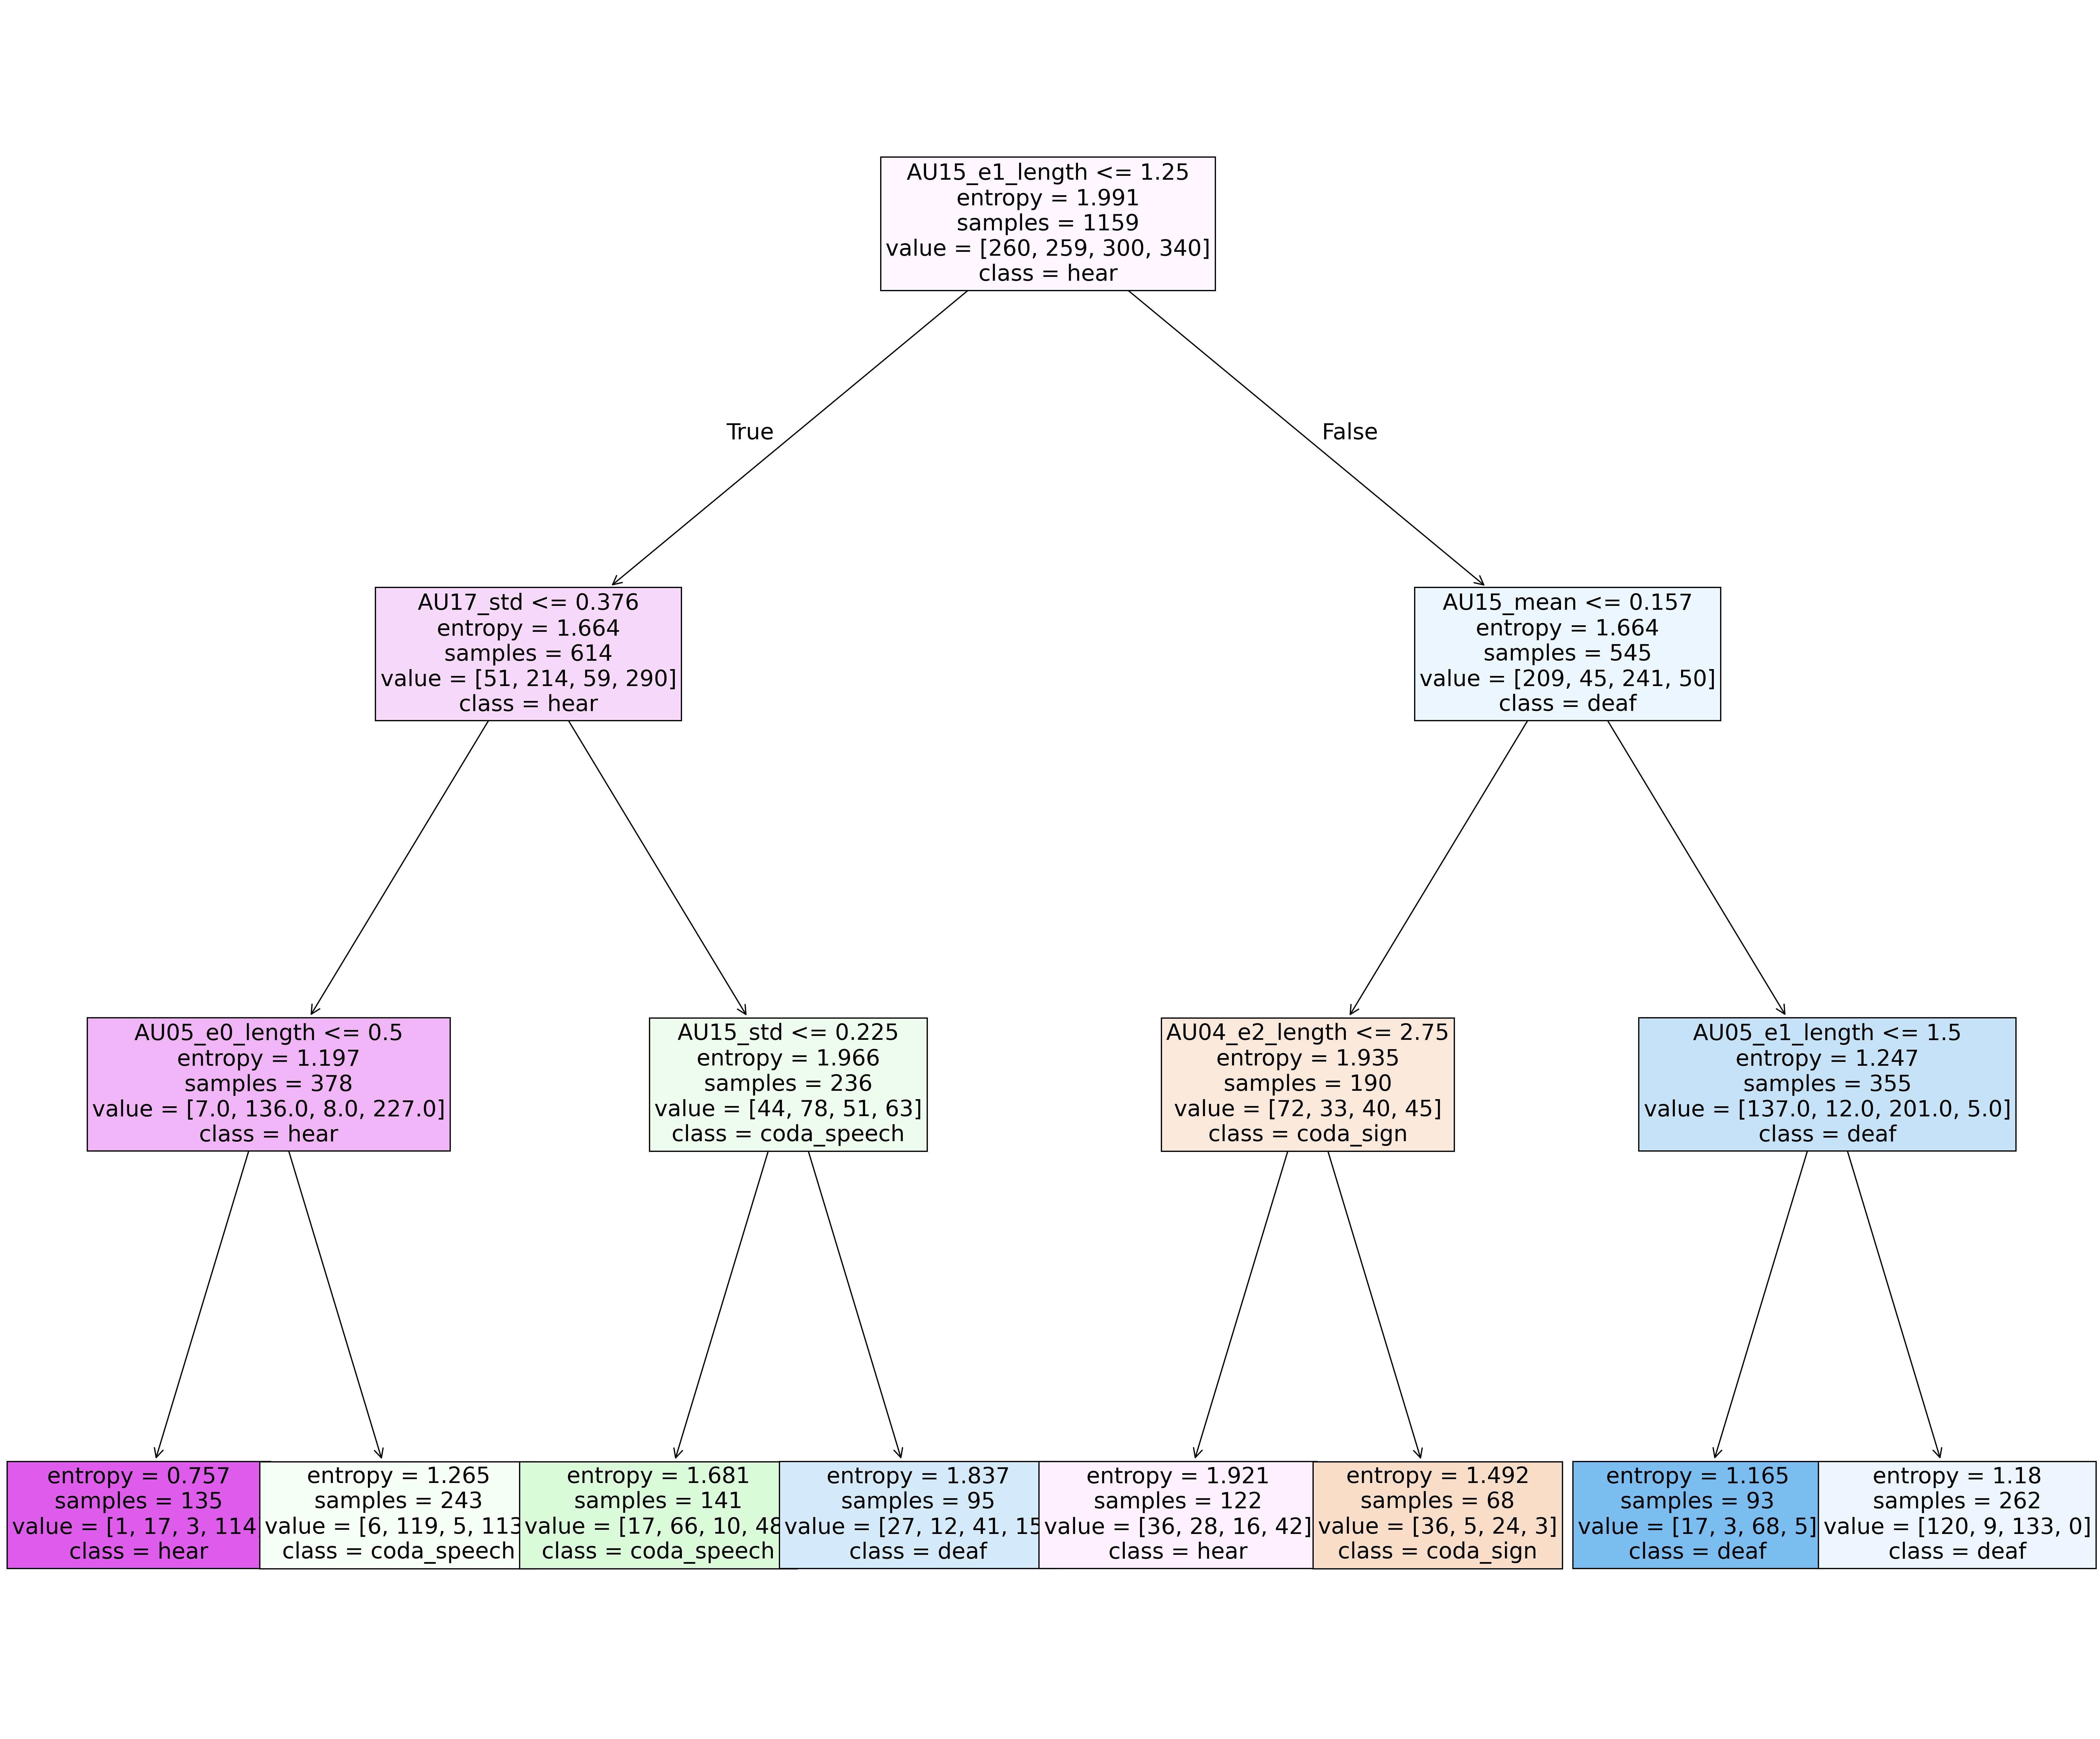

In [46]:
clf = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=3)
clf.fit(df, labels)


fig = plt.figure(figsize=(30,25), dpi=300)
tree.plot_tree(clf, filled=True, fontsize = 18, feature_names = df.columns.tolist(), class_names=label_names)
# plt.savefig('out.jpeg')